# Basic dispersion relation calculations
This example shows basic functionalities of the SpinWaveToolkit (SWT) regarding the spin-wave (SW) dispersion relation and derived quantities: group velocity, lifetime, and decay length. The most general model is also the most commonly used one - the `SingleLayer` class. It implements the formula of Kalinikos and Slavin [[*J. Phys. C: Solid State Phys.*, **19**, 7013 (1986)]](https://doi.org/10.1088/0022-3719/19/35/014).

Let's start by importing needed modules and defining the problem using material parameters of the ferromagnetic layer and the propagation geometry.

In [1]:
# import modules
import numpy as np  # for vectorization
import matplotlib.pyplot as plt  # for plotting
import SpinWaveToolkit as SWT

In [ ]:
# Define material properties using custom parameters
mat = SWT.Material(
    Ms=800e3,   # (A/m) saturation magnetization
    Aex=16e-12,  # (J/m) exchange stiffness
    alpha=0.007,  # () damping
    gamma=28.8*1e9*2*np.pi  # (rad*Hz/T) gyromagnetic ratio
)
# or use built-in materials (NiFe, YIG, CoFeB, FeNi)
mat = SWT.NiFe

# Define the propagation geometry
d = 100e-9  # (m) layer thickness
Bext = 50e-3  # (T) external magnetic field
theta = np.pi/2  # (rad) for in-plane magnetization
phi = np.pi/2  # (rad) for Damon-Eshbach geometry
k = np.linspace(0, 25e6, 200) + 1  # (rad/m) SW wavenumber range
# Note the +1 above used to avoid badly conditioned calculations at k=0
bc = 1 # boundary condition (1 - totally unpinned, 2 - totally pinned spins)


Now we can calculate the dispersion relation for Damon-Eshbach SWs ($\mathbf{k}\perp \mathbf{M}$ or $\phi=\pi/2$). It's easy to also switch to backward volume geometry ($\mathbf{k}\parallel \mathbf{M}$ or $\phi=0$).

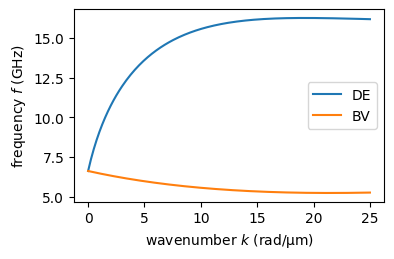

In [3]:
# Instantiate the SingleLayer class
sl = SWT.SingleLayer(Bext, mat, d, k, theta, phi, boundary_cond=bc)

f_de = sl.GetDispersion()/(2e9*np.pi)  # (GHz) DE SW dispersion
sl.phi = 0  # switch to backward volume geometry
f_bv = sl.GetDispersion()/(2e9*np.pi)  # (GHz) BV SW dispersion

fig = plt.figure(figsize=(4, 2.5))
plt.plot(k*1e-6, f_de, label="DE")
plt.plot(k*1e-6, f_bv, label="BV")
plt.xlabel(r"wavenumber $k$ (rad/µm)")
plt.ylabel(r"frequency $f$ (GHz)")
plt.legend(loc="center right")
plt.show()

To calculate higher-order perpendicular standing spin-wave (PSSW) modes, just supply the mode number to the `sl.GetDispersion()` method. *Note that this model uses only diagonal elements of the system matrix, therefore hybridizations between modes are neglected (see further).*

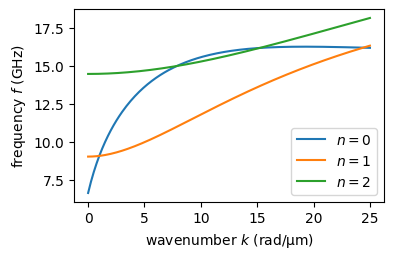

In [4]:
nmodes = 3  # number of PSSW modes to calculate
sl.phi = np.pi/2  # switch back to Damon-Eshbach geometry
fig = plt.figure(figsize=(4, 2.5))
for i in range(nmodes):
    f_de_pssw = sl.GetDispersion(i)/(2e9*np.pi)  # (GHz) DE SW dispersion
    plt.plot(k*1e-6, f_de_pssw, label=f"$n=${i}")
plt.xlabel(r"wavenumber $k$ (rad/µm)")
plt.ylabel(r"frequency $f$ (GHz)")
plt.legend(loc="lower right")
plt.show()

## The properties derived from the dispersion relation
Now if we want to explore further the SW properties, we can use numerical approaches to derive e.g. the group velocity $v_{\mathrm{g}}$, lifetime $\tau$, and consequently also the decay length $\lambda=v_{\mathrm{g}}\tau$. All the calculations are handled by the respective methods of the `SingleLayer` class. 

*Note: Whenever possible, all the SWT classes of dispersion models use the same syntax for getting the dispersion relation, group velocity, etc.*

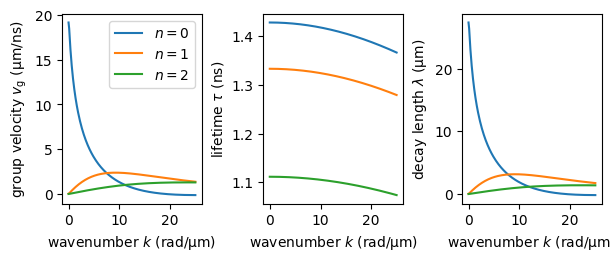

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2.5), constrained_layout=True)
for i in range(nmodes):
    vg_de = sl.GetGroupVelocity(i)*1e-3  # (um/ns)
    tau_de = sl.GetLifetime(i)*1e9  # (ns)
    lam_de = sl.GetDecLen(i)*1e6  # (um)

    ax[0].plot(k*1e-6, vg_de, label=f"$n=${i}")
    ax[1].plot(k*1e-6, tau_de)
    ax[2].plot(k*1e-6, lam_de)
    ax[i].set_xlabel(r"wavenumber $k$ (rad/µm)")
ax[0].set_ylabel(r"group velocity $v_{\mathrm{g}}$ (µm/ns)")
ax[1].set_ylabel(r"lifetime $\tau$ (ns)")
ax[2].set_ylabel(r"decay length $\lambda$ (µm)")
ax[0].legend(loc="upper right")
plt.show()

## Numeric calculation of the dispersion relation
So far, the dispersion relation was calculated using analytically derived formulas. In most cases it is sufficient, but there are systems (thick films, films with surface anisotropy, etc.), where it can be misleading. Therefore the `SWT.SingleLayerNumeric` class implements a model with a 6×6 system matrix, which eigenvalues (eigenfrequencies of the system) can describe 3 lowest-order SW modes. This approach solves the eigenvalue problem numerically, including the off-diagonal elements. This means that the mode hybridizations and splitting can be more easily modelled. It is based on the model of Tacchi et al. [[*Phys. Rev. B* **100**, 104406 (2019)]](https://doi.org/10.1103/PhysRevB.100.104406).

*Note: The* `SingleLayer` *class can also calculate mode hybridizations using the perturbation theory up to the second-order. as is described in the source article (see above).*

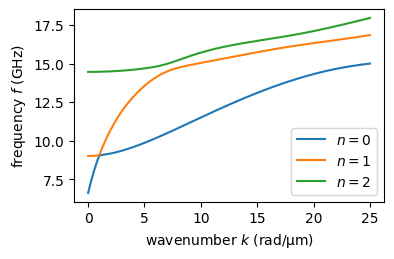

In [6]:
# Instantiate the SingleLayerNumeric class with the same parameters as above
sln = SWT.SingleLayerNumeric(Bext, mat, d, k, theta, phi)

f_de_num = sln.GetDispersion()[0]/(2e9*np.pi)  # (GHz) dispersion for 3 lowest modes

fig = plt.figure(figsize=(4, 2.5))
for i in range(f_de_num.shape[0]):
    plt.plot(k*1e-6, f_de_num[i], label=f"$n=${i}")
plt.xlabel(r"wavenumber $k$ (rad/µm)")
plt.ylabel(r"frequency $f$ (GHz)")
plt.legend(loc="lower right")
plt.show()

As one can see, the mode crossings are now avoided, mainly at higher $k$ (where the dipolar interaction between modes is stronger). Note that this effect arises just due to the dipolar interaction by including the off-diagonal elements of the system matrix.

Another advantage of the numeric approach is that it also computes the eigenvectors of the system matrix, which represent the mode profiles across the film thickness. How to calculate those is shown in the `NumericCalculationOfModeProfiles.ipynb` example.
`### Update the example and then its name here.`